# TD Optim Linéaire : Planification de la production d'électricité
### Guillaume DESERMEAUX, Mastère OSE 2023
(Sujet de Sophie demassey, CMA - Mines Paris-PSL) 5 Octobre 2023
# Partie 1

In [1]:
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt

import gurobipy as gp
from gurobipy import  Model, GRB, multidict # Object utile pour créer des dictionnaires à partir d'une table

# I.5) Implémentation du modèle de base
On stocke les coefficients dans un multidict et crée un modèle GUROBI.

In [2]:
Periods, start_time, stop_time, duration, demand = multidict({
    1: ["0h", "6h", 6, 15],
    2: ["6h", "9h", 3, 30],
    3: ["9h", "15h", 6, 25],
    4: ["15h", "18h", 3, 40],
    5: ["18h", "0h", 6, 27]
})

Centrales, Ndisp, P_min, P_max, cmw = multidict({
    'A': [ 12, 850, 2000, 1.5],
    'B': [ 10, 1250, 1750, 1.38],
    'C': [5, 1500, 4000, 2.75]
})

Mw2Gw = lambda x : x / 1000
Gw2Mw = lambda x : x * 1000

# Create a new model
m = gp.Model()

Set parameter TokenServer to value "dev.cma.mines-paristech.fr"


In [3]:
# Create variables
# Total thermal power of the plants A, B, C for every period
Y = m.addVars(Periods, Centrales, 
              lb = 0,
              #ub = [ Mw2Gw(P_max[c])*Ndisp[c] for c, p in product(Centrales, Periods) ],
              name = 'Production',
              vtype = GRB.CONTINUOUS)

X = m.addVars(Periods, Centrales,
              lb = 0,
              ub = [ (Ndisp[c] for p in Periods for c in Centrales ) ],
              name = 'Number_plants', 
              vtype = GRB.INTEGER)
m.update()

In [4]:
# Set objective function
total_cost = sum( [ duration[p]*cmw[c]*Gw2Mw(Y[(p, c)]) for p in Periods for c in Centrales ] )
obj = m.setObjective(total_cost, gp.GRB.MINIMIZE)
#print(total_cost)

In [5]:
# Add constraints
# Demand on the network
c_demand = m.addConstrs( ( Y.sum(p, '*') >= demand[p] 
                                   for p in Periods ), name = "Demand" ) 
# Power constraints on the plants
c_p_min = m.addConstrs( (  Y[(p, c)] >= Mw2Gw(P_min[c])*X[(p, c)]
                                  for c in Centrales for p in Periods ), name = "Pmin" )
c_p_max = m.addConstrs( ( Y[(p, c)] <= Mw2Gw(P_max[c])*X[(p, c)] 
                                  for c in Centrales for p in Periods ), name = "Pmax" )
m.update()

In [6]:
print(c_demand)

{1: <gurobi.Constr Demand[1]>, 2: <gurobi.Constr Demand[2]>, 3: <gurobi.Constr Demand[3]>, 4: <gurobi.Constr Demand[4]>, 5: <gurobi.Constr Demand[5]>}


In [7]:
#for c in m.getConstrs():
#    print(m.getRow(c))

In [8]:
m.write("PowerOptim_MO.lp")

In [9]:
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 35 rows, 30 columns and 75 nonzeros
Model fingerprint: 0x30e2df03
Variable types: 15 continuous, 15 integer (0 binary)
Coefficient statistics:
  Matrix range     [8e-01, 4e+00]
  Objective range  [4e+03, 2e+04]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e+01, 4e+01]
Found heuristic solution: objective 1379250.0000
Presolve removed 28 rows and 24 columns
Presolve time: 0.01s
Presolved: 7 rows, 6 columns, 15 nonzeros
Found heuristic solution: objective 940650.00000
Variable types: 3 continuous, 3 integer (0 binary)

Root relaxation: objective 8.694000e+05, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

{'obj': 869400.0, 'lb': 869400.0, 'gap': 0.0, 'time': 0.01699995994567871}
plan to activate units: {'A': [0, 12, 4, 12, 5], 'B': [9, 10, 10, 10, 10], 'C': [0, 0, 0, 0, 0]}


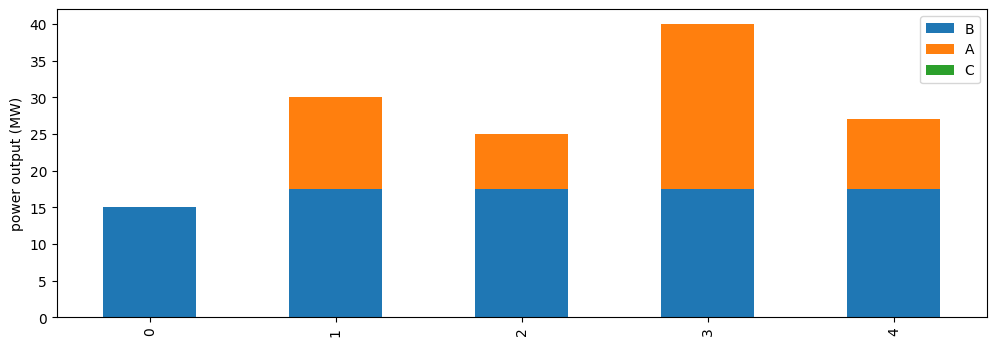

In [10]:
# solution characteristics
result = {'obj': m.objVal, 'lb': m.objBound,  'gap': m.mipGap, 'time': m.runtime}
print(result)

# optimal plan
ndict = {t: [int(v.x) for v in X.select('*', t)] for t in Centrales}
print(f"plan to activate units: {ndict}")

orderedgen = sorted(Centrales, key=lambda x: cmw[x])
pdict = {t: [v.x for v in Y.select('*', t)] for t in orderedgen}
powerdf = pd.DataFrame(data=pdict)

fig, axs = plt.subplots(figsize=(12, 4))
powerdf.plot.bar(stacked=True, ax=axs)
axs.set_ylabel("power output (MW)")
fig.savefig("powergen_1.5.png")
plt.show()

Implémenter le modèle mathématique (1.1). Ce programme mathématique comprend-il des variables
discrètes ? Le cas échéant, identier, décrire et comparer les valeurs best objective, best bound, root relaxa-
tion objective et heuristic solution retournées par Gurobi. Lesquelles parmi ces valeurs sont des bornes
inférieures (ou bornes duales) ou supérieures (ou bornes primales ) de l'optimum global ? Ce modèle
possède-t-il la propriété d'unimodularité ?

On obtient les résultats suivants : 
- Best objective 8.694000000000e+05, (Le coût minimal trouvé à la fin de l'optimisation) C'est une borne supérieure (borne primale)
- best bound 8.694000000000e+05, (Le coût du meilleur minimum trouvé. Ici le min) C'est une borne inférieures (borne duale)
- root relaxation objective 8.694000e+05 (Le résultat du problème relaxé donc sans les contraintes d'intégralité) C'est une borne inférieures (borne duale)
- Found heuristic solution: objective 1379250.0000 ( C'est une solution trouvé avec une contrainte de temps. Elle n'est donc pas optimale)  

Le modèle possède la propriété d'unimodularité car la solution du problème relaxé est entière.

# I.6) Implémentation de la relaxation continue

In [11]:
m_relax = m.relax()
m_relax.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 35 rows, 30 columns and 75 nonzeros
Model fingerprint: 0xef7d53e2
Coefficient statistics:
  Matrix range     [8e-01, 4e+00]
  Objective range  [4e+03, 2e+04]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e+01, 4e+01]
Presolve removed 31 rows and 18 columns
Presolve time: 0.00s
Presolved: 4 rows, 12 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7370000e+05   4.850000e+01   0.000000e+00      0s
       4    8.6940000e+05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.694000000e+05


In [12]:
# optimal plan
ndict = {t: [int(v.x) for v in X.select('*', t)] for t in Centrales}
print(f"plan to activate units: {ndict}")

plan to activate units: {'A': [0, 12, 4, 12, 5], 'B': [9, 10, 10, 10, 10], 'C': [0, 0, 0, 0, 0]}


### Explication :
- On trouve les mêmes valeurs d'optimum pour le problème relaxé et discret. Ceci est logique car la valeur de relaxation continue est entière.
- La valeur initiale à la racine du modèle discrêt est de 1379250.0000. Elle est bien supérieure à la valeur de la relaxation continue car c'est la valeur de coût avant l'optimisation.
- On prouve que le merit order est bien optimale dans ce cas car on a le même résultat que celui calculé théoriquement au 1.2.

# I.7) Reformulation de la relaxation continue

In [13]:
## Create a new model
m2 = gp.Model()
# Total thermal power of the plants A, B, C for every period
Y = m2.addVars(Periods, Centrales,
              name = 'Production',
              vtype = GRB.CONTINUOUS)
## Set objective function
total_cost = sum( [ duration[p]*cmw[c]*Gw2Mw(Y[(p, c)]) for p in Periods for c in Centrales ] )
obj = m2.setObjective(total_cost, gp.GRB.MINIMIZE)
## Add constraints
# Demand on the network
c_demand = m2.addConstrs( ( Y.sum(p, '*') >= demand[p] 
                for p in Periods ), name = "Demand" ) 
# Power constraints on the plants
c_p_max = m2.addConstrs( ( Y[(p, c)] <= Mw2Gw(P_max[c])*Ndisp[c]
                for c in Centrales for p in Periods ), name = "Pmax" )
## optimize
m2.update()
m2.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 20 rows, 15 columns and 30 nonzeros
Model fingerprint: 0x94cf7827
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+03, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+01]
Presolve removed 16 rows and 3 columns
Presolve time: 0.00s
Presolved: 4 rows, 12 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7370000e+05   4.850000e+01   0.000000e+00      0s
       4    8.6940000e+05   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Optimal objective  8.694000000e+05


In [14]:
# optimal plan
ndict = {t: [int(v.x) for v in X.select('*', t)] for t in Centrales}
print(f"plan to activate units: {ndict}")

plan to activate units: {'A': [0, 12, 4, 12, 5], 'B': [9, 10, 10, 10, 10], 'C': [0, 0, 0, 0, 0]}


On trouve les mêmes résultats que précédement.

On a une variante du problème du sac a dos mais dans le cas ou on minimise le coût et on contraint sur une demande minimale (Au lieux de maximiser l'utilité et de contraindre sur la capacité max). Les coût marginaux 

In [15]:
shadow_price = m2.getAttr('Pi', m2.getConstrs())

In [16]:
# Coûts marginaux :
for sp, constr in zip(shadow_price, m2.getConstrs()):
    print(f"Shadow price of {constr} is {sp}")

Shadow price of <gurobi.Constr Demand[1]> is 8280.0
Shadow price of <gurobi.Constr Demand[2]> is 4500.0
Shadow price of <gurobi.Constr Demand[3]> is 9000.0
Shadow price of <gurobi.Constr Demand[4]> is 4500.0
Shadow price of <gurobi.Constr Demand[5]> is 9000.0
Shadow price of <gurobi.Constr Pmax[A,1]> is 0.0
Shadow price of <gurobi.Constr Pmax[A,2]> is 0.0
Shadow price of <gurobi.Constr Pmax[A,3]> is 0.0
Shadow price of <gurobi.Constr Pmax[A,4]> is 0.0
Shadow price of <gurobi.Constr Pmax[A,5]> is 0.0
Shadow price of <gurobi.Constr Pmax[B,1]> is 0.0
Shadow price of <gurobi.Constr Pmax[B,2]> is -360.0
Shadow price of <gurobi.Constr Pmax[B,3]> is -720.0
Shadow price of <gurobi.Constr Pmax[B,4]> is -360.0
Shadow price of <gurobi.Constr Pmax[B,5]> is -720.0
Shadow price of <gurobi.Constr Pmax[C,1]> is 0.0
Shadow price of <gurobi.Constr Pmax[C,2]> is 0.0
Shadow price of <gurobi.Constr Pmax[C,3]> is 0.0
Shadow price of <gurobi.Constr Pmax[C,4]> is 0.0
Shadow price of <gurobi.Constr Pmax[C,5]> 

In [17]:
# Valeurs des variables d'écart
for sp, constr in zip(m2.getAttr(GRB.Attr.Slack),  m2.getConstrs()):
    print(f"Variables d'écart de la contrainte {constr} est {sp}")

Variables d'écart de la contrainte <gurobi.Constr Demand[1]> est 0.0
Variables d'écart de la contrainte <gurobi.Constr Demand[2]> est 0.0
Variables d'écart de la contrainte <gurobi.Constr Demand[3]> est 0.0
Variables d'écart de la contrainte <gurobi.Constr Demand[4]> est 0.0
Variables d'écart de la contrainte <gurobi.Constr Demand[5]> est 0.0
Variables d'écart de la contrainte <gurobi.Constr Pmax[A,1]> est 24.0
Variables d'écart de la contrainte <gurobi.Constr Pmax[A,2]> est 11.5
Variables d'écart de la contrainte <gurobi.Constr Pmax[A,3]> est 16.5
Variables d'écart de la contrainte <gurobi.Constr Pmax[A,4]> est 1.5
Variables d'écart de la contrainte <gurobi.Constr Pmax[A,5]> est 14.5
Variables d'écart de la contrainte <gurobi.Constr Pmax[B,1]> est 2.5
Variables d'écart de la contrainte <gurobi.Constr Pmax[B,2]> est 0.0
Variables d'écart de la contrainte <gurobi.Constr Pmax[B,3]> est 0.0
Variables d'écart de la contrainte <gurobi.Constr Pmax[B,4]> est 0.0
Variables d'écart de la contra

In [18]:
# Coûts réduits : ( De combien le prix de la centrale doit baisser sur la période pour qu'elle s'allume )
# 
for sp, constr in zip(m2.getAttr(GRB.Attr.RC), Y):
    print(f"Reduced cost of Puissance{constr} is {sp}")

Reduced cost of Puissance(1, 'A') is 720.0
Reduced cost of Puissance(1, 'B') is 0.0
Reduced cost of Puissance(1, 'C') is 8220.0
Reduced cost of Puissance(2, 'A') is 0.0
Reduced cost of Puissance(2, 'B') is 0.0
Reduced cost of Puissance(2, 'C') is 3750.0
Reduced cost of Puissance(3, 'A') is 0.0
Reduced cost of Puissance(3, 'B') is 0.0
Reduced cost of Puissance(3, 'C') is 7500.0
Reduced cost of Puissance(4, 'A') is 0.0
Reduced cost of Puissance(4, 'B') is 0.0
Reduced cost of Puissance(4, 'C') is 3750.0
Reduced cost of Puissance(5, 'A') is 0.0
Reduced cost of Puissance(5, 'B') is 0.0
Reduced cost of Puissance(5, 'C') is 7500.0
